## DL for Time Series

Методы, основанные на глубоком обучении, отличаются от классических (ARIMA и тд.). При помощи DL мы стремимся получить глобальную вероятностную модель.

- Глобальность / локальность – классические методы при наличии нескольких рядов, как правило, обучаются на каждом по-отдельности. В DL можно действовать глобально, т.е. улавливая взаимосвязи между рядами.

- Вероятностный / точечный прогноз – классические методы, как правило, дают точечный прогноз, в то время как методы DL позволяют моделировать распределение вероятности, а именно оптимизировать параметры распредления из заранее заданного семейства, например, нормального или Стьюдента, (гиперпараметр).  
  

**Transformers for TS**   
Временные ряды – это последовательности, поэтому логично, что трансформер с энкодер-декодерной архитектурой является естественным выбором для работы с подобным типом данных.

Чтобы обучить модель, нам нужно определиться с длиной контекста – в том числе исходя из соображений затрат ресурсов на вычисления и память, – а затем сэмплировать из ряда окна, состоящие из контекста (окно контекста) и последующих значений (окно предсказаний). Первое передаем в энкодер, второе – в декодер с использованием masked attention (не подглядывя вперед). Как правило, декодирование происходит по алгоритму teacher forcing – после того, как мы сгенерировали значение и посчитали на нем ошибку, сравнив с ground truth, мы обучаем декодер генерировать следующее значение исходя из ground truth значения.

Одним из преимуществ архитектуры является то, что мы с легкостью можем обрабатывать пропущенные значения (частая проблема временных рядов) без необходимости их заполнения. Это делается при помощи дополнительной маски, схожей по смыслу с attention_mask в NLP, которая используется для исключения padding токенов из расчета матрицы attention.

Из основных недостатков архитектуры – квадратичные требования по ресурсам в классической модели (для решения этой проблемы придуманы различные вариации – Informer, Autoformer, FEDformer, Pyraformer и тд), а также склонность к переобучению на шум из-за большого количества параметров по сравнению с количеством имеющихся в распоряжении данных.

**Полезные материалы**:    
- <a href="https://github.com/huggingface/notebooks/blob/main/examples/time_series_datasets.ipynb">github.com/huggingface</a> - Туториал по Hugging Face datasets для временных рядов
- <a href="https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html#What-is-in-a-dataset?">ts.gluon.ai</a> - Туториал по GluonTS для временных рядов
- <a href="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/seminars/sem07_ts2/sem07_ts2.ipynb">github.com/hse-ds</a> - Семинар по работе с временными рядами
- <a href="https://otexts.com/fpp3/">otexts.com</a> - Учебник Forecasting: Principles and Practice

In [38]:
# !pip install gluonts
# !pip install --upgrade datasets
# !pip install lightning
# !pip install evaluate

# import shutil
# import pathlib
# cache_path = pathlib.Path.home() / ".cache" / "huggingface" / "datasets" # Путь к папке кеша
# shutil.rmtree(cache_path)  # Удаляем весь кеш - потеря всех скачанных датасетов
# !pip install --upgrade datasets

In [46]:
from copy import deepcopy
import gdown, os, zipfile, random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Декоратор lru_cache из модуля functools используется для сохранение результатов выполнения функций,
# запоминает результаты вызова функции с определенными аргументами и возвращает сохраненный результат при повторном вызове
# с теми же аргументами, что позволяет ускорить работу, особенно в случае рекурсивных функций или функций, выполняющих ресурсоемкие вычисления
from functools import lru_cache
from functools import partial

from typing import Optional
from typing import Iterable

from datasets import load_dataset
from accelerate import Accelerator
from evaluate import load

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction, PretrainedConfig

from gluonts.transform.sampler import InstanceSampler
from gluonts.dataset.field_names import FieldName
from gluonts.itertools import Cyclic, IterableSlice, PseudoShuffled
# from gluonts.torch.util import IterableDataset
from gluonts.time_feature import (time_features_from_frequency_str, TimeFeature, get_seasonality, get_lags_for_frequency)
from gluonts.transform import (AddAgeFeature, AddObservedValuesIndicator, AddTimeFeatures, AsNumpyArray, Chain, ExpectedNumInstanceSampler,
                               InstanceSplitter, RemoveFields, SelectFields, SetField, TestSplitSampler, Transformation, ValidationSplitSampler, 
                               VstackFeatures, RenameFields)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# from gluonts.torch.util import IterableDataset
# from torch.utils.data.dataset import IterableDataset
from torch.utils.data import IterableDataset

class IteratorDataset(IterableDataset):  # Обертка для итератора
    def __init__(self, iterator):
        super().__init__()
        self._iterator = iterator

    def __iter__(self):
        return self._iterator

In [47]:
# Используем датасет tourism_monthly из репозитория Monash Time Series Forecasting. Его можно считать каноническим бенчмарком в области ts
# Monash University - крупнейший университет Австралии - занимает сильные позиции в сфере пронозирвания ts
# download_mode="force_redownload", cache_dir=None, cache_dir="/tmp", cache_dir="./my_cache"
dataset = load_dataset("monash_tsf", "tourism_monthly")
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [48]:
# В каждом поднаборе 366 рядов, по числу регионов в стране. Каждый ряд, в свою очередь, состоит из нескольких связанных сущностей,
# из которых start и target являются самыми важными: start - начальная точка (в формате datetime), target - непосредственные значения ряда
train_example = dataset["train"][0]
print(train_example.keys())
print(train_example["start"])
print(train_example["target"])

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])
1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.97497

In [49]:
display(pd.DataFrame(dataset["train"]).head())
pd.DataFrame(dataset["train"])['start'].agg(['min', 'max'])

,start,target,feat_static_cat,feat_dynamic_real,item_id
0,1979-01-01,"[1149.8699951171875, 1053.8001708984375, 1388....",[0],None,T1
1,1979-01-01,"[65072.37109375, 48612.19921875, 58452.5898437...",[1],None,T2
2,1985-01-01,"[37047.0, 32836.0, 51094.0, 52629.0, 56884.0, ...",[2],None,T3
3,1985-01-01,"[7611.0, 6859.0, 9247.0, 10924.0, 9064.0, 7417...",[3],None,T4
4,1985-01-01,"[27693.0, 15075.0, 22602.0, 23530.0, 26817.0, ...",[4],None,T5


,start
min,1979-01-01
max,2000-01-01


In [50]:
# Валидационная выборка состоит из тех же данных, что и тренировочная, но с добавлением (длиннее на) prediction_length. Тестовая, в свою очередь, на prediction_length длиннее валидационной
validation_example = dataset["validation"][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [51]:
# начальные значения валидационной идентичны начальным значениям обучающей
print(validation_example["start"])
print(validation_example["target"])

print(len(train_example["target"]))
print(len(validation_example["target"]))

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [52]:
# Проверим, что объект из валидационного датасета действительно на prediction_length=24 длиннее, чем объект из обучающего
freq = "1M"
prediction_length = 24
assert len(train_example["target"]) + prediction_length == len(validation_example["target"])

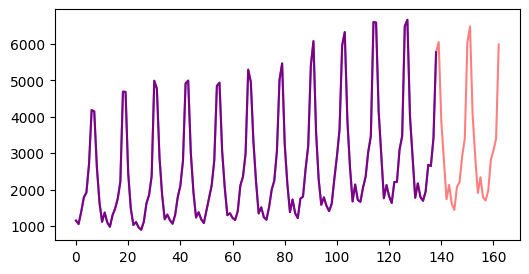

In [53]:
figure, axes = plt.subplots(figsize = (6,3))
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()

In [54]:
# Выделим из данных отдельно трейн и тест
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [55]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 366
})

In [56]:
# Сконвертируем признак start в объект типа pd.Period (в качестве аргумента дополнительно передадим freq)
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [57]:
# При помощи datasets' set_transform применим преобразование к трейну и тесту
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

**Задание модели**   
Обучение будет проводиться с нуля, поэтому вместо from_pretrained инициализируем веса случайно с задействованием объекта config.       



В него необходимо передать следующие аргументы:   

- prediction_length (24 месяца): горизонт предсказания декодера;
- context_length: глубина ряда на вход энкодера; по умолчанию равен prediction_length, если не указано иначе;
- lags – лаги ряда;   
- количество т.н. time, или temporal features (служат своего рода positional encoding'ами): в нашем случае 2, так как мы добавляем MonthOfYear и Age – число, которое будет указывать модели на абсолютную позицию значения во временном ряде, сродни счетчику, сквозная нумерация;   
- количество статических категориальных признаков (не меняющихся с течением времени): в нашем случае всего 1, так как мы используем единственный признак такого типа "time series ID";   
- cardinality: список, состоящий из количеств возможных значений каждого из статических категориальных признаков; в нашем случае это список из одного элемента [366], так как в нашем распоряжении 366 различных рядов – по числу регионов страны;   
- размерность эмбеддинга: список, состоящий из размерностей эмбеддингов для каждого статического категориального признака; в нашем случае, к примеру, [2] будет означать, что каждый ряд (регион) будет кодироваться вектором размерности 2    



Можно использовать стандартные лаги, которые GluonTS автоматически рассчитывает для каждой частотности данных (в нашем случае "monthly"):

In [58]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [59]:
# А также time features по умолчанию:
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function month_of_year at 0x7d6e4aed5ee0>]


Получили всего один time feauture признак, а именно "month of year". (1- "январь", 2- "февраль" и тд.). "age" будет добавлен позже.

In [60]:
# Инициализация модели
config = TimeSeriesTransformerConfig(prediction_length=prediction_length,        # горизонт предсказания декодера
                                      context_length=prediction_length * 2,      # глубина ряда на вход энкодера; по умолчанию равен prediction_length, если не указано иначе
                                      lags_sequence=lags_sequence,               # лаги ряда
                                      num_time_features=len(time_features) + 1,  # MonthOfYear и Age (число, которое будет указывать модели на абсолютную позицию значения во временном ряде, счетчик)
                                      num_static_categorical_features=1,         # количество статических категориальных признаков (не меняющихся с течением времени): в нашем случае всего 1 -timeSeriesID
                                      cardinality=[len(train_dataset)],          # список, состоящий из количеств возможных значений каждого из статических категориальных признаков
                                      embedding_dimension=[2],                   # размерность эмбеддинга: список, состоящий из размерностей эмбеддингов для каждого статического категориального признака
                                     # distribution_output=StudentTOutput()  - по умолчанию
                                     # параметры непосредственно трансформера:
                                      encoder_layers=4, decoder_layers=4, d_model=32)
model = TimeSeriesTransformerForPrediction(config)

Модель TimeSeriesTransformerModel - базовая трансформерная модель с архитектурой "энкодер-декодер", которая сама по себе не включает слой для генерации вероятностного распределения. Она реализует только предсказание временного ряда без конкретной оценки риска или неопределенности. В то время как TimeSeriesTransformerForPrediction - это расширенная версия, которая, кроме основной архитектуры, включает "distribution head" — слой на выходе, отвечающий за моделирование распределения предсказаний. Это позволяет моделировать вероятностные характеристики предсказаний, например, доверительные интервалы. По умолчанию используется распределение Стьюдента (гиперпараметр, можно изменить)

In [61]:
# Тип распределения, которое будет использоваться при моделировании выходных данных
# По умолчанию — распределение Стьюдента
model.config.distribution_output

'student_t'

При использовании трансформеров для задач NLP выход как правило представляет из себя дискретное распределение над алфавитом, и реализуется посредством nn.Linear.   

В нашем случае модель выучивает распределение, из которого можно впоследствии сэмплировать, и не выдает напрямую значения как таковые.

**Преобразования данных и генерация признаков**   

Используем GluonTS: определим объект Chain, в который поместим преобразования по аналогии с тем, как это происходит в torchvision.transforms.Compose для изображений

In [62]:
FieldName.FEAT_STATIC_CAT

'feat_static_cat'

In [63]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # формируем список полей для удаления
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # как torchvision.transforms.Compose
    return Chain(
        # шаг 1: удаляем поля, занесенные в список для удаления
        [RemoveFields(field_names=remove_field_names)]
        # шаг 2: переводим данные в numpy формат
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # предусмотрим дополнительную размерность на случай, если работаем с многомерными рядами:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # шаг 3: заполняем NaN в таргете нулями и вазвращаем маску observed_values
            # FALSE для пропущенных значений, TRUE иначе
            # маска учитывется декодером (значение функции потерь по unobserved игнорируется)
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # шаг 4: добавляем temporal features на основе частотности данных
            # месяц года (freq="M"). Такие признаки служат своего рода positional encoding'ами
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # шаг 5: добавляем еще temporal feature - число, которое будет указывать модели на абсолютную позицию значения во временном ряде
            # своего рода счетчик (сквозная нумерация)
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # шаг 6: стэкаем temporal features по вертикали на ключ FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: переименовываем поля для соответствия HuggingFace обозначениям
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

**Даталоадеры**   
Необходимо создать промежуточный InstanceSplitter. Он необходим для сэмплирования "окон" из датасета (длины context_length и длины следующего за ним prediction_length), а также добавления в них соответствующих меток past_ и future_. Таким образом values распадутся на past_values и следующие за ними future_values, и будут служить входами для энкодера и декодера соответственно.

In [64]:
# InstanceSplitter

In [65]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(target_field="values",
                            is_pad_field=FieldName.IS_PAD,
                            start_field=FieldName.START,
                            forecast_start_field=FieldName.FORECAST_START,
                            instance_sampler=instance_sampler,
                            past_length=config.context_length + max(config.lags_sequence),
                            future_length=config.prediction_length,
                            time_series_fields=["time_features", "observed_mask"])

In [ ]:
# from gluonts.torch.util import IterableDataset
# from torch.utils.data.dataset import IterableDataset
from torch.utils.data import IterableDataset

# Обертка для итератора/генератора
class IteratorDataset(IterableDataset):
    def __init__(self, iterator):
        super().__init__()
        self._iterator = iterator

    def __iter__(self):
        return self._iterator

**Инициализация даталоадеров**      
Создадим даталоадеры и получим батчи (input, output) – т.е. past_values, future_values

In [66]:
def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)

    # инициализируем Instance для трейна
    instance_splitter = create_instance_splitter(config, "train") + SelectFields(TRAINING_INPUT_NAMES)

    # будет проводиться случайное сэмплирование подспоследовательностей длины
    # длина контекста + максимальное значение лага + горизонт предсказания
    # (из всех 366 преобразованных индивидуальных рядов)
    # и возвращает итератор.
    # максимальное значение лага фигурирует тут постольку, поскольку для лагов нужна доп. глубина
    training_instances = instance_splitter.apply(
        Cyclic(transformed_data)
        if shuffle_buffer_length is None
        else PseudoShuffled(
            Cyclic(transformed_data),
            shuffle_buffer_length=shuffle_buffer_length,
        )
    )
    dataset = IteratorDataset(iter(training_instances))
    # имея итератор для трейн датасета, мы получаем Dataloader
    # который будет сэмплировать случайные окна в количестве batch_size
    # и, собственно, содержать тензоры, готорые для подачи в модель
    return IterableSlice(
        iter(
            DataLoader(
                dataset,
                batch_size=batch_size,
                **kwargs,
            )
        ),
        num_batches_per_epoch,
    )

In [67]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # создадим Instance для теста, который будет брать сэмплы из последних
    # в каждом ряде окон контекста с тем, чтобы передавать их исключительно в энкодер
    instance_sampler = create_instance_splitter(config, "test") + SelectFields(PREDICTION_INPUT_NAMES)

    # применяем преобразования на тесте
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    # Оборачиваем в наш класс-обертку
    dataset = IteratorDataset(iter(testing_instances))

    # возвращаем даталоадер
    return DataLoader(dataset, batch_size=batch_size, **kwargs)

In [68]:
train_dataloader = create_train_dataloader(config=config,
                                            freq=freq,
                                            data=train_dataset,
                                            batch_size=256,
                                            num_batches_per_epoch=100)
test_dataloader = create_test_dataloader(config=config,
                                          freq=freq,
                                          data=test_dataset,
                                          batch_size=64)

In [69]:
train_dataloader

**Пробный батч и пробный forward pass**

In [70]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 85, 2]) torch.FloatTensor
past_values torch.Size([256, 85]) torch.FloatTensor
past_observed_mask torch.Size([256, 85]) torch.FloatTensor
future_time_features torch.Size([256, 24, 2]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.LongTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


In [71]:
outputs = model(past_values=batch["past_values"],
                past_time_features=batch["past_time_features"],
                past_observed_mask=batch["past_observed_mask"],
                static_categorical_features=batch["static_categorical_features"]
                if config.num_static_categorical_features > 0
                else None,
                static_real_features=batch["static_real_features"]
                if config.num_static_real_features > 0
                else None,
                future_values=batch["future_values"],
                future_time_features=batch["future_time_features"],
                future_observed_mask=batch["future_observed_mask"],
                output_hidden_states=True)

In [72]:
print("Loss:", outputs.loss.item())

Loss: 9.219844818115234


**Обучаем модель**   

Задействуем модули библиотеки Accelerate, которая в автоматическом режиме поместит модель, оптимизатор и даталоадер на нужный device.

In [73]:
accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(model,
                                                        optimizer,
                                                        train_dataloader)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(static_categorical_features=batch["static_categorical_features"].to(device)
                        if config.num_static_categorical_features > 0
                        else None,
                        static_real_features=batch["static_real_features"].to(device)
                        if config.num_static_real_features > 0
                        else None,
                        past_time_features=batch["past_time_features"].to(device),
                        past_values=batch["past_values"].to(device),
                        future_time_features=batch["future_time_features"].to(device),
                        future_values=batch["future_values"].to(device),
                        past_observed_mask=batch["past_observed_mask"].to(device),
                        future_observed_mask=batch["future_observed_mask"].to(device))
        loss = outputs.loss
        accelerator.backward(loss)   # Обратное распространение ошибки 
        optimizer.step()             # Изменение весов

        if idx % 100 == 0:
            print(loss.item())

9.028557777404785
7.663218021392822
7.47986364364624
7.181878566741943
7.317785263061523
6.865039825439453
6.832464218139648
7.266886234283447
7.572513580322266
6.722412109375
7.005434036254883
7.659908294677734
6.952360153198242
6.668398380279541
7.56691312789917
6.585981845855713
7.229892730712891
7.376275539398193
6.741880893707275
6.712100982666016
7.643594264984131
6.724790096282959
7.543687343597412
7.148512363433838
7.239843845367432
7.310890197753906
6.6599907875061035
6.961019039154053
7.106327056884766
7.516269683837891
6.587063312530518
7.07974100112915
6.704017639160156
7.393152713775635
6.933888912200928
6.920501708984375
7.232472896575928
7.362576961517334
6.623968601226807
7.123173236846924


**Inference**   
На инференсе, как и в NLP, используем метод generate(), реализующий авторегрессионную генерацию.   

Под капотом мы задействуем test instance sampler, который берет из рядов сэмплы последних окон контекста для передачи в энкодер. В декодер же поступают future_time_features (мы всегда знаем их заранее).

In [74]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

На выходе модели получаем массивы размерности (batch_size, number of samples, prediction length).

В процессе авторегрессионной генерации мы сэмплируем 100 различных значений для каждого из 24 месяцев прогнозного горизонта (для каждого из 64 объектов в батче):

In [75]:
forecasts[0].shape  # (64, 100, 24)

(64, 100, 24)

In [76]:
# Настэкав их по вертикали, мы получим прогноз для всех рядов в тестовом датасете
forecasts = np.vstack(forecasts)
print(forecasts.shape)  # (366, 100, 24)

(366, 100, 24)


Для оценки используем библиотеку Evaluate, в которой реализованы метрики MASE, MAPE.   



In [77]:
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)  # берем медианное значение сэмплов

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(predictions=forecast_median[item_id],
                                references=np.array(ground_truth),
                                training=np.array(training_data),
                                periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(predictions=forecast_median[item_id],
                                references=np.array(ground_truth))
    smape_metrics.append(smape["smape"])

In [78]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 1.7638408530725842


In [79]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.1934052417913542


In [80]:
def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(start=test_dataset[ts_index][FieldName.START],
                            periods=len(test_dataset[ts_index][FieldName.TARGET]),
                            freq=freq).to_timestamp()

    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(index[-2 * prediction_length :],
            test_dataset[ts_index]["target"][-2 * prediction_length :],
            label="actual")

    plt.plot(index[-prediction_length:],
            np.median(forecasts[ts_index], axis=0),
            label="median")

    plt.fill_between(index[-prediction_length:],
                    forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
                    forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
                    alpha=0.3,
                    interpolate=True,
                    label="+/- 1-std")
    plt.legend()
    plt.show()

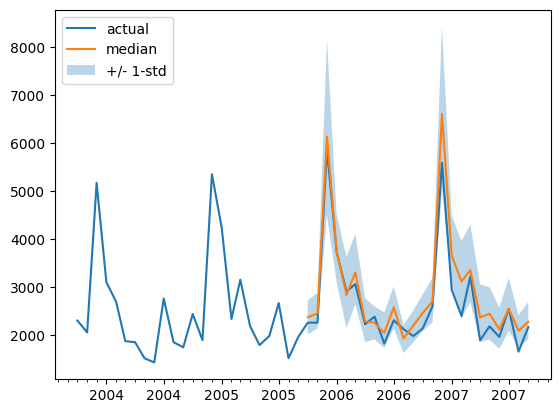

In [81]:
plot(334)